We are looking at the Travelling Salesman Problem, which can be mathematically formulated as : \
We have a set of $n$ cities, with $w_{i,j}$ being the distance between the city $i$ and the city $j$. The goal is to find the shortest path visiting every city exactly once and returning to the first city. We note $x_{i,t}$ a boolean variable, such that $x_{i,t}= 1$ if the $i$-th city is visited at timestep $t$, and  $x_{i,t}= 0$ otherwise.
Thus, our goal is to find $x \in \{0, 1\}^{n^2}$ which minimizes the cost function :
$$C_{\text{cost}}(x) = \sum_{0 \leq i,j<n} w_{i,j} \sum_t x_{i,t}x_{j, t+1}$$
Since we can only visit a given city once, and we can only be at one city at a given time, we also have the following constraints :
$$ \sum_{0\leq i <n } x_{i,t} = 1, \ \forall t \in [\![0, n-1]\!] $$
$$\sum_{0\leq t <n } x_{i,t} = 1, \ \forall i \in [\![0, n-1]\!] $$




To enforce the constraints, we will use a penalization term in the cost function. Essentially, we will use the cost function $C =  C_{\text{cost}} + M\cdot C_{\text{penalty}}$ where :
$$ C_{\text{penalty}} = \sum_{t}\left( 1 - \sum_{i} x_{i,t} \right)^2 + \sum_i \left(1 - \sum_t x_{i,t} \right)^2 $$
And $M$ is a constant large enough for the penalization to be efficient. Notice there are constant terms in $C_{\text{penalty}}$, which we will remove in the hamiltonian, and notice that the total cost function is quadratic in the variables $x_{i,t}$, meaning we can map it onto a Ising Hamiltonian using the correspondance $x_{i,j} \leftrightarrow \frac12(1-Z_{i,t})$ where $Z_{i,t}$ is the pauli operator $Z$ acting on the qubit $i,t$.
We note the cost Hamiltonian : 
$$ \hat{H}_C = \sum_{x \in  \{ 0, \ 1 \}^n } C(x) \ket{x}\bra{x}$$
which is diagonal in the computationnal basis, and in terms of operators is equivalent to replacing every $x_{i,t}$ in $C(x)$ by $\frac12(1-Z_{i,t})$. We start the code with the imports for using MyQLM, and the initialization of the problem : 

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program,RX, X, H, Y, Z, S, PH, RZ, RY
from qat.opt import CombinatorialProblem
from qat.vsolve.ansatz import AnsatzFactory
from qat.pylinalg import PyLinalg
from qat.qpus import get_default_qpu
from qat.clinalg import CLinalg
from qat.plugins import ScipyMinimizePlugin
from qat.plugins import SPSAMinimizePlugin
from qat.core import Result
from qat.core.qpu import QPUHandler
from qat.core import Result
from qat.core.wrappers.result import aggregate_data


In [2]:
nb_cities = 3  # number of cities
nbLayers = 10 #number of optimization layers for QAOA
C = [[0, 1, 1000], [1000, 0, 1], [1, 1000, 0]]  # Cost matrix of the travel between two cities
constraint_constant = 10*nb_cities # Constraint constant, this one works well

Then we use MyQLM's functions to construct the hamiltonian corresponding to the cost function :

In [3]:
#Create a combinatorial problem
problem = CombinatorialProblem("TSP", False)
#initialize the boolean variables
var_array = problem.new_vars(nb_cities**2)
# Now we create the cost function as a boolean function

# This part corresponds to the actual cost function
for i in range(nb_cities):
    for j in range(nb_cities):
        for t in range(nb_cities - 1):
            problem.add_clause(
                var_array[i + nb_cities * t]
                & var_array[j + nb_cities * ((t + 1) % nb_cities)],
                C[i][j],
            )

# This part corresponds to the penalisation added to the cost function, with the constant terms removed
for t in range(nb_cities):
    for i in range(nb_cities):
        problem.add_clause(var_array[i + nb_cities * t], (-2) * constraint_constant)
        for i2 in range(nb_cities):
            if i2 != i:
                problem.add_clause(
                    var_array[i + nb_cities * t] & var_array[i2 + nb_cities * t],
                    constraint_constant,
                )
        
        for t2 in range(nb_cities):
            if t2 != t:
                problem.add_clause(
                    var_array[i + nb_cities * t] & var_array[i + nb_cities * t2],
                    constraint_constant,
                )

Now that our cost function has been created, we use the qaoa_ansatz method to create our job, which is a runable parametrized QAOA circuit, corresponding to preparing the state : 
$$\ket{\Phi(\vec{\gamma},\vec{\beta} )}=  \prod_1^p e^{-i\beta_i \hat{H}_B} e^{-i\gamma_i \hat{H}_C} \ket{+}. $$
Where $\hat{H}_B = \sum_1^n X_i $ où $X_i$

In [4]:
observable = problem.get_observable()
observable

Observable(terms=[Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=0.25, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='ZZ', qbits=[0, 4], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=0.25, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='ZZ', qbits=[3, 7], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=250.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='ZZ', qbits=[0, 5], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=250.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='ZZ', qbits=[8, 3], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=250.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='ZZ', qbits=[1, 3], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=Fa

In [13]:
epochs =10
for i in range(epochs):
    observable = problem.get_observable()
    prog = Program()
    # list_1qbit_gates = [X, Y, Z, H, PH, RZ, RX, RY]
    # list_2qb_gates = [
    #         X.ctrl(1),
    #         Z.ctrl(1),
    #     ]

    reg = prog.qalloc(nb_cities**2)
    var =  [ prog.new_var(float,'theta'+str(i)) for i in range(nb_cities**2)]
    # for i in range(nb_cities**2):
    #     test= np.random.choice([True,False])
    #     if test:
    #         gate_to_apply = np.random.choice(list_1qbit_gates)
    #         if hasattr(gate_to_apply, "parameters"):
    #             if isinstance(gate_to_apply.parameters, list) and len(gate_to_apply.parameters) > 0:
    #                 gate_to_apply = gate_to_apply(np.random.uniform(0, 2 * np.pi))
    #         prog.apply(gate_to_apply, reg[i])
    #  else:
    #    switch=np.random.choice([True,False])
    # Alternate position every 2-qubits layer
       # if switch:
        #    for j in np.arange(0, nb_cities - 1, 2):
        #        prog.apply(np.random.choice(list_2qb_gates), reg[j], reg[j + 1])

#            switch = False

 #       else:
  #          for j in np.arange(1, nb_cities - 2, 2):
   #             prog.apply(np.random.choice(list_2qb_gates), reg[j], reg[j + 1])

    #        switch = True
    #prog.apply(X, reg[i])
    for i in range(nb_cities**2):
        prog.apply(RX(var[i]),reg[i])
    circ = prog.to_circ()
    job = circ.to_job(observable=observable)
    optimize =ScipyMinimizePlugin(method="BFGS", tol=1e-5, options={"maxiter": 150}, x0 =np.array([0.01]*nb_cities**2)) #L'optimiseur 
    qpu = PyLinalg()
    stack =  optimize | qpu #on crée un stack : on va lancer le optimize sur le job qui sera soumis
    result = stack.submit(job) #résultat de l'optimisation
    circuit = job.circuit.bind_variables(result.parameter_map) #On récupère le circuit précédent en 
    #spécifiant les variables (qui sont celles de l'optimiseur)
    job = circuit.to_job(nbshots = 10000) #Le second job, qui va nous permettre de connaître l'état du vecteur avec 10000 mesures
    qpu = PyLinalg()
    result = qpu.submit(job) #Résultat des mesures
    probasRes = np.zeros(2**(nb_cities**2))
    for sample in result:
        print("State %s amplitude %s" % (sample.state, sample.probability))
        bitstring = sample.state.bitstring
        i = int(bitstring, base=2)
        probasRes[i] = sample.probability
        #s = format(i, 'b').zfill(nb_cities**2)

State |100010001> amplitude 1.0
State |100010001> amplitude 1.0


KeyboardInterrupt: 

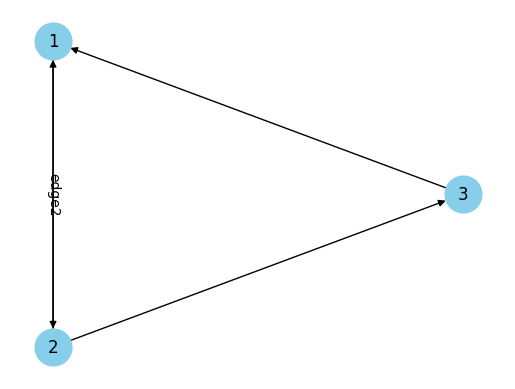

In [15]:
import networkx as nx
G=nx.DiGraph()
G.add_node(3)
G.add_node(1)
G.add_node(2)
G.add_edge(1,2,label='edge1')
G.add_edge(2,1,label='edge2')
G.add_edge(2,3)
G.add_edge(3,1)
pos = nx.circular_layout(G)  # Positionnement circulaire pour une meilleure visualisation

nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue")
